In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import random

import cv2
import numpy as np

import open3d as o3d
import copy

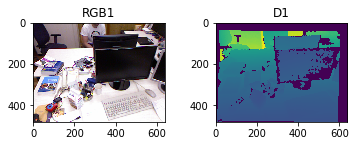

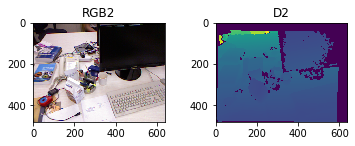

In [75]:
# Load and visualize images

color_raw1 = o3d.io.read_image('rgb1.png')
depth_raw1 = o3d.io.read_image('depth1.png')
rgbd_image1 = o3d.geometry.RGBDImage.create_from_tum_format(color_raw1, depth_raw1, convert_rgb_to_intensity=False)

color_raw2 = o3d.io.read_image('rgb2.png')
depth_raw2 = o3d.io.read_image('depth2.png')
rgbd_image2 = o3d.geometry.RGBDImage.create_from_tum_format(color_raw2, depth_raw2, convert_rgb_to_intensity=False)

rgb1 = np.asarray(rgbd_image1.color)
rgb2 = np.asarray(rgbd_image2.color)

depth1 = np.asarray(rgbd_image1.depth)
depth2 = np.asarray(rgbd_image2.depth)

plt.subplot(2, 2, 1)
plt.title('RGB1')
plt.imshow(rgbd_image1.color)
plt.subplot(2, 2, 2)
plt.title('D1')
plt.imshow(rgbd_image1.depth)
plt.show()
plt.subplot(2, 2, 3)
plt.title('RGB2')
plt.imshow(rgbd_image2.color)
plt.subplot(2, 2, 4)
plt.title('D2')
plt.imshow(rgbd_image2.depth)
plt.show()

In [76]:
# Camera intrinsics, focal length and focal points

width = 640
height = 480
fx = 517.306408
fy = 516.469215
cx = 318.643040
cy = 255.313989

# Coefficients for undistortion

k1 = 0.262383
k2 = -0.953104
p1 = -0.005358
p2 = 0.002628
k3 = 1.163314

# Point cloud visualizater from open3d, please note o3d.visualization.draw_geometries() will open a window.
# Check the results and CLOSE the pop-up window to proceed to the next cell.

pinholeCameraIntrinsic = o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

pinholeCameraIntrinsic.set_intrinsics(width=width, height=height, fx=fx, fy=fy, cx=cx, cy=cy)

print(pinholeCameraIntrinsic)
print(pinholeCameraIntrinsic.intrinsic_matrix)

pcd1 = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image1,
        pinholeCameraIntrinsic)

pcd2 = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image2,
        pinholeCameraIntrinsic)

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

draw_registration_result(pcd2, pcd1, np.identity(4))

camera::PinholeCameraIntrinsic with width = 640 and height = 480.
Access intrinsics with intrinsic_matrix.
[[517.306408   0.       318.64304 ]
 [  0.       516.469215 255.313989]
 [  0.         0.         1.      ]]


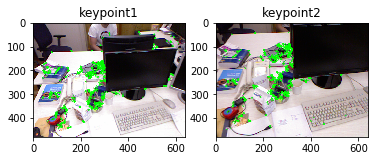

In [77]:
# Extract orb features and draw them on the images

orb = cv2.ORB_create(nfeatures=1200)

kp1, des1 = orb.detectAndCompute(rgb1, None)
kp2, des2 = orb.detectAndCompute(rgb2, None)

rgb11 = cv2.drawKeypoints(rgb1, kp1, None, color=(0,255,0), flags=0)
rgb22 = cv2.drawKeypoints(rgb2, kp2, None, color=(0,255,0), flags=0)

plt.subplot(1, 2, 1)
plt.title('keypoint1')
plt.imshow(rgb11)
plt.subplot(1, 2, 2)
plt.title('keypoint2')
plt.imshow(rgb22)
plt.show()

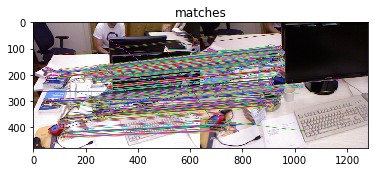

In [78]:
# Brute force matching, crossCheck flag is for reciprocal check. 
# Set it to false will results in more wrong matches.

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)

img12 = cv2.drawMatches(rgb1, kp1, rgb2, kp2, matches, None, flags=2)

plt.title('matches')
plt.imshow(img12)
plt.show()

In [79]:
# Reformatting the keypoint from CVKeypoint to numpy array.
uv1 = np.array([k.pt for k in kp1]).astype(np.float32)
uv2 = np.array([k.pt for k in kp2]).astype(np.float32)

# Discard points have no depths from RGB-D camera.
ind1 = []
ind2 = []
for cnt in range(len(matches)):
      
    dep2 = depth2[np.rint(uv2[matches[cnt].trainIdx, 1]).astype(int), np.rint(uv2[matches[cnt].trainIdx, 0]).astype(int)]
    if dep2 < 1e-3:
        continue
    
    ind1.append(uv1[matches[cnt].queryIdx])
    ind2.append([uv2[matches[cnt].trainIdx, 0], uv2[matches[cnt].trainIdx, 1], dep2])

ind1 = np.array(ind1, np.float32)
ind2 = np.array(ind2, np.float32)
ind2_raw = ind2.copy()

# List points into 3D with projection function.
ind2[:,0] = (ind2[:,0] - cx) * ind2[:,2] / fx
ind2[:,1] = (ind2[:,1] - cy) * ind2[:,2] / fy
 
K = np.eye(3)
K[0,0] = fx 
K[1,1] = fy
K[0,2] = cx
K[1,2] = cy

distCoeffs = np.array([k1,k2,p1,p2,k3])
print(K)
print(distCoeffs)

[[517.306408   0.       318.64304 ]
 [  0.       516.469215 255.313989]
 [  0.         0.         1.      ]]
[ 0.262383 -0.953104 -0.005358  0.002628  1.163314]


In [80]:
# RANSAC for PnP, students are required to finish two parts: (1) eval_pnp() function and (2) the actuall RANSAC loop.

def eval_pnp(ind1, ind2, inliers, cameraMatrix, distCoeffs, do_projection=False):
    
    retval, rvecs, t = cv2.solvePnP(ind2[inliers], ind1[inliers], cameraMatrix=K, distCoeffs=distCoeffs)

#     (1) Required part for student, some hints: check projectPoints function from opencv for warping keytpoints
#         between frames. Think about how to get the residual as a metric to the quality of the aligment.

    R = cv2.Rodrigues(rvecs)[0]

    T = np.identity(4)
    T[:3,:3] = R
    T[:3,3] = t.flatten()
    
    if do_projection:
        ind2_projected, _ = cv2.projectPoints(ind2, rvecs, t, K, distCoeffs)
        ind2_projected = ind2_projected.squeeze()

        return T, residual, ind2_projected

    return T, residual
 
# set up total iteration times for ransac, set ransac_iter_num to 1 to check how it looks withou RANSAC.

index_all = range(ind1.shape[0])
ransac_iter_num = 1000

residual_best = None
T_best = None
inliers_best = None


for iter_ind in range(ransac_iter_num):
    
    inliers_candidate = random.sample(index_all, 10)    
    T, residual = eval_pnp(ind1, ind2, inliers_candidate, cameraMatrix=K, distCoeffs=distCoeffs)
    
#    (2) Required part for student, finishing find the best inlier set based on the RANSAC algorithm, 
#     i.e., find and store the best model during randome sampling.

#         print("Found new best absolution residual: {}".format(residual_best))

# EXPERIMENT AND COMMENT ON THE BEHAVIOUR WITH THESE SETTINGS: RESIDUALS WITH AND WITHOUT RANSAC

Found new best absolution residual: 853.4302368164062
Found new best absolution residual: 6.928166389465332
Found new best absolution residual: 6.917405605316162
Found new best absolution residual: 6.898233890533447


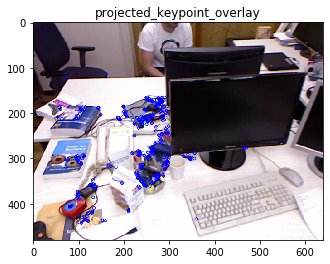

In [81]:
# Visualize the best model by drawing warped points into the same frame.

T_best, residual_best, ind2_projected_inlier = eval_pnp(ind1, ind2, inliers_best, cameraMatrix=K, distCoeffs=distCoeffs, do_projection=True)

def corners_to_keypoints(corners):
    if corners is None:
        keypoints = []
    else:
        keypoints = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in corners]
    return keypoints

rgb111 = cv2.drawKeypoints(rgb1, corners_to_keypoints(ind1[inliers_best]), None, color=(0,255,0), flags=0)
rgb111 = cv2.drawKeypoints(rgb111, corners_to_keypoints(ind2_projected_inlier), None, color=(0,0,255), flags=0)

plt.title('projected_keypoint_overlay')
plt.imshow(rgb111)
plt.show()

# Check the results and CLOSE the pop-up window to proceed to the next cell.
draw_registration_result(pcd2, pcd1, T_best)

# EXPERIMENT AND COMMENT ON THE BEHAVIOUR WITH THESE SETTINGS: VISUALIZATION OF ALIGNMENTS WITH AND WITHOUT RANSAC

In [82]:
# Extra part: use the estimated pose from PnP with RANSAC using keypoint, refine it with dense ICP.
# Try to notice the improvement via the visualization, the changes should be noticable.

threshold = 0.02
trans_prior = T_best

print("Apply point-to-point ICP using keypoint estimated pose.")
reg_p2p = o3d.registration.registration_icp(
        pcd2, pcd1, threshold, trans_prior,
        o3d.registration.TransformationEstimationPointToPoint())
# print(reg_p2p)

print("Prior transformation is:")
print(trans_prior)
print("Refined transformation is:")
print(reg_p2p.transformation)
draw_registration_result(pcd2, pcd1, reg_p2p.transformation)

# EXPERIMENT AND COMMENT ON THE BEHAVIOUR WITH THESE SETTINGS: WITH AND WITHOUT REFINEMENT

Apply point-to-point ICP using keypoint estimated pose.
Prior transformation is:
[[ 0.99962294  0.0048827  -0.02702094 -0.01729431]
 [-0.0024647   0.99604591  0.08880581  0.03633287]
 [ 0.0273477  -0.08870573  0.99568238  0.25608983]
 [ 0.          0.          0.          1.        ]]
Refined transformation is:
[[ 9.99575104e-01  1.62524562e-03 -2.91027461e-02 -2.12752408e-02]
 [ 8.74764656e-04  9.96321917e-01  8.56847254e-02  3.52095005e-02]
 [ 2.91349625e-02 -8.56737763e-02  9.95897162e-01  2.17238259e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
